In [2]:
from datasets import load_dataset
import io
from PIL import Image
from matplotlib import pyplot as plt


/home/taehwan/micromamba/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
ds = load_dataset("flwrlabs/femnist")
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'writer_id', 'hsf_id', 'character'],
        num_rows: 814277
    })
})

In [4]:
dataframe = ds["train"]


In [5]:
dataframe = dataframe.to_pandas()

18


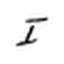

In [43]:
dataframe[dataframe["hsf_id"] == 7]["image"].iloc[7]
print(dataframe[dataframe["hsf_id"] == 7]["character"].iloc[7])
Image.open(io.BytesIO(dataframe[dataframe["hsf_id"] == 7]["image"].iloc[7]["bytes"])).resize((64,64), Image.LANCZOS)

hsf_id
0    174421
1    162729
2    135787
3     89210
4     82593
6     85778
7     83759
Name: count, dtype: int64

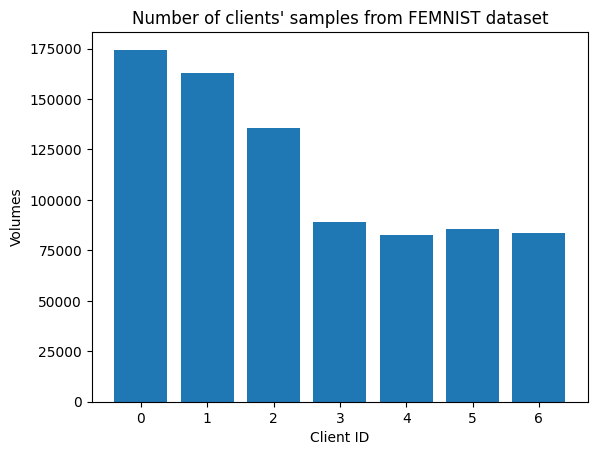

In [6]:
plt.bar(range(7), dataframe["hsf_id"].value_counts().sort_index())
plt.xlabel("Client ID")
plt.ylabel("Volumes")
plt.title("Number of clients' samples from FEMNIST dataset")
dataframe["hsf_id"].value_counts().sort_index()